In [1]:
%matplotlib inline

# Introduction

## Key Problems with ML in Chemistry

1. Translational Variance
2. Rotational Variance
3. Permutation Variance

Traditional ML algorithms struggle with making molecular predictions because of the nature of how we represent molecules. Typically, a molecule in space is represented as a 3D cartesian array, typically of shape (points, 3). Something like a Neural Network (NN) cannot operate on an array like this, because each position in the array doesn't mean something on it's own. For example, a molecule could have one cartesian array centered at (0, 0, 0), and another centered at (15, 15, 15). Both arrays represent the same molecule, but numerically they are very different. This is an example of **translational variance**. A similar example exists for **rotational variance**, but imagine rotating the molecule by $90^{\circ}$ instead of translating the molecule. In both of these examples, inputting the two different arrays which represent a single molecule would result in the NN seeing the arrays as representing **different** molecules, which they are not. Much work has gone into creating novel **input representations** for molecules in an attempt to resolve problems with translational and rotational variance.

### Translational Variance Fix

We can solve the translational variance problem by computing the distance matrix of a molecule to obtain a representation of the molecule that is **invariant** to translation. However, in practice, a distance matrix array of shape (N, N) has a **single number** to characterize the distance between two points. Simply put, there is not enough **explicit information** contained within a distance matrix array to be useful to a NN. However, expanding that single number into a vector which probes various distances provides a more sparse representation, but one which is ultimately more **explicit**. An implementation of this idea, known as Atom-centered symmetry functions ([Behler, 2011](https://aip.scitation.org/doi/10.1063/1.3553717)) achieve this representation. These symmetry functions probe continuous space with gaussian functions centered on a grid, descretizing the provided molecular distance matrix. As each position on the grid **explicitly** means something (e.g. two points positioned exactly $1.42e^{-10}m$ apart), the network is capable of making inferences from each position in the array.

Grid visualization: [desmos](https://www.desmos.com/calculator/4bncqy2bol)

#### Basis Function Demonstration

cartesians shape: (5, 15, 3)
distance_matrix shape: (5, 15, 15)
image shape: (5, 15, 15, 80)


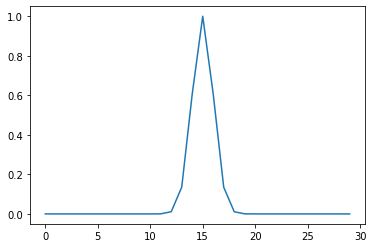

In [3]:
# Package written by Trevor Profitt, modified for TF 2.0 by Riley Jackson
from tfn.layers.atomic_images import DistanceMatrix, GaussianBasis
import numpy as np
from matplotlib import pyplot as plt

# batch, points, 3
np.random.seed(0)
cartesians = np.random.randint(1, 5, size=(5, 15, 3)).astype('float32')
print('cartesians shape: {}'.format(cartesians.shape))
distance_matrix = DistanceMatrix()(cartesians)
print('distance_matrix shape: {}'.format(distance_matrix.shape))
image = GaussianBasis(
    width=0.2,
    spacing=0.2,
    min_value=-1.0,
    max_value=15.0
)(distance_matrix)
print('image shape: {}'.format(image.shape))

# (batch, points, points, functions)
plt.plot(image[0, 0, 1, :30])
plt.axis(xlim=16.0, ylim=1.0)
plt.show()

### Permutation Variance Fix

The ordering of points in an input tensor is meaningless in a molecular context, so we must be careful to avoid ever depending on this ordering. We can achieve this by only ever operating the network atom-wise to obtain **atomic property predictions**. Whenever we want to predict **molecular properties**, we must use cummulative combinations of these atomic predictions (e.g. summation).

### Rotational Variance Fix

Atom-centered symmetry functions are rotationally **invariant** because the distance matrix is invariant. The is fine for networks which predict scalar values from molecules, e.g. energy. However, for problems that are direction dependent, we want rotational **equivariance**, where the output of the network rotations *the same* as the input, e.g. force prediction, molecular dynamics, etc.

Need a network that can encode directional information and feed it forward to influence outputs. Enter the **Tensor Field Networks**.

# Tensor Field Networks

Tensor Field Networks (TFN) are **Rotationally Equivariant Continuous Convolution Neural Networks** which are capable of inputing continuous 3D point-clouds (e.g. molecules) and making scalar, vector, and higher order tensor predictions which rotate with the original input point-cloud ([Thomas et. al. 2018](https://arxiv.org/abs/1802.08219)).

Ignoring the **continuous convolution** part, this means that TFNs are capable of knowing when an image has been rotated, something vanilla convolution nets are not capable of.

For example, a traditional conv. net trained to recognize cats on **non-rotated images** would not identify a cat in the second picture:

![cat](cat_pic.png) ![cat_rotated](cat_pic_rotated.png)

While TFNs will still identify a cat in the rotated image, trained only on images in a single orientation. We can convince ourselves this is true by visualizing TFNs outputing a vector upon input of a molecule:

#### Equivariance Demonstration

tensorflow version: 2.0.0
eager mode on: True
Train on 5 samples
Epoch 1/2
5/5 [==============================] - 3s 629ms/sample - loss: 0.4732
Epoch 2/2
5/5 [==============================] - 0s 72ms/sample - loss: 0.4692
equivariance perserved: True
angle between predicted vectors: 44.04207229614258


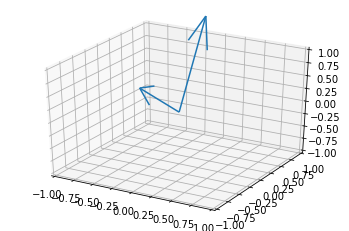

In [4]:
import tensorflow as tf
import numpy as np
import math

from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Model

print('tensorflow version: {}\neager mode on: {}'.format(tf.__version__, tf.executing_eagerly()))

def rotation_matrix(axis_matrix=None, theta=math.pi/2):
    """
    Return the 3D rotation matrix associated with counterclockwise rotation about
    the given `axis` by `theta` radians.

    :param axis_matrix: np.ndarray. Defaults to [1, 0, 0], the x-axis.
    :param theta: float. Defaults to pi/2. Rotation in radians.
    """
    axis_matrix = axis_matrix or [1, 0, 0]
    axis_matrix = np.asarray(axis_matrix)
    axis_matrix = axis_matrix / math.sqrt(np.dot(axis_matrix, axis_matrix))
    a = math.cos(theta / 2.0)
    b, c, d = -axis_matrix * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

class MyModel(Model):
    def __init__(self, max_z: int = 5):
        super().__init__(dynamic=True)
        self.max_z = max_z
        self.embedding = SelfInteraction(16)
        self.conv_0 = MolecularConvolution()
        self.conv_1 = MolecularConvolution(si_units=1, output_orders=[1])

    def call(self, inputs, training=None, mask=None):
        r, z = inputs
        one_hot, image, vectors = Preprocessing(self.max_z)([r, z])
        features = self.embedding(K.expand_dims(one_hot, axis=-1))
        output = self.conv_0([one_hot, image, vectors] + features)
        output = self.conv_1([one_hot, image, vectors] + output)[0]
        output = K.squeeze(output, axis=-2)
        return K.mean(output, axis=1)  # (batch, 3)

    def compute_output_shape(self, input_shape):
        r, z = input_shape
        batch, *_ = r
        return tf.TensorShape([batch, 3])

# Set up random input/target data, instantiate model
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
cartesians = np.random.rand(5, 29, 3)
atomic_nums = np.random.randint(0, 5, size=[5, 29])
vectors = np.random.rand(5, 3)
model = MyModel()
model.compile(optimizer='adam', loss='mae', run_eagerly=True)
model.fit(x=[cartesians, atomic_nums], y=vectors, epochs=2, batch_size=5)

# Make predictions on normal/rotated vectors
predicted_vectors = model.predict([cartesians, atomic_nums])
R = rotation_matrix([1, 0, 0], theta=math.pi/4)
rotated_cartesians = np.dot(cartesians, R)
rotated_predicted_vectors = model.predict([rotated_cartesians, atomic_nums])
print('equivariance perserved: {}'.format(
    np.alltrue(
        np.isclose(
            np.dot(predicted_vectors, R), rotated_predicted_vectors,
            rtol=0.,
            atol=1e-5
        )
    )
))

# Matplotlib display stuff
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
pv, rpv = predicted_vectors[0], rotated_predicted_vectors[0]
ax.quiver(
    [0, 0], [0, 0], [0, 0],
    [pv[0], rpv[0]], [pv[1], rpv[1]], [pv[2], rpv[2]],
    length =2, normalize = True
)
cosang = np.dot(pv, rpv)
sinang = np.linalg.norm(np.cross(pv, rpv))
print('angle between predicted vectors: {}'.format(np.rad2deg(np.arctan2(sinang, cosang))))

plt.show()

## Tensor Field Networks are powerful... How do they work?

TFNs combine continuous convolution (i.e. a filter generating neural network) with the spherical harmonics to produce **spherically symmetric filters** (dubbed Harmonic Filters) which are point-convolved with feature tensors associated with the 3D point-cloud. These Harmonic Filters are capable of convolving with features associated with the point-cloud (e.g. atom type information for molecules, mass, velocity, acceleration, etc.) to produce outputs which rotate **equivariantly** with the input point-cloud.

#### Spherical Harmonics

The Spherical Harmonics are a set of orthogonal basis functions defined on the surface of a sphere. They can be utilized to represent any function which exists on a sphere. They have many special properties, however, for our purposes, we are interested in their **spherical symmetry**. The filters of our network are composed of a directionless **Radial** function and the real component of the spherical harmonic function centered on the unit-vectors of our point-cloud.

We're not mathematicians, so the important thing to know is that the spherical symmetry of the spherical harmonics provide the filters of our network with **rotational equivariance**. The implementation of these basis functions is quite simple due to a few shortcuts, which we'll see soon.

#### Tensor Rotation Order

Feature tensors that are part of the group $S(O3)$ (i.e. tensors that rotate normally in 3D), require $2l + 1$ dimensions to be represented. "$l$" is referred to as the **rotation order** of that tensor. e.g. an array which represents a scalar value has rotation order $l=0$, and an array representing a vector has rotation order $l=1$.
e.g. an *energy* (scalar) array for a batch of molecules would have the shape **(molecules, points, 1)**, while a *force* (vector) array for a batch of molecules would have shape **(molecules, points, 3)**.

Once again, we're not mathematicians, so all we need to know is that rotation order refers to the **rank** of what our feature tensor *represents*, and that we can only combine tensors of varying rotation order in **specific ways** if we hope to conserve **rotational equivariance**.

#### Equivariant Combination Types

The combination rules are essentially the traditional ways of combining scalars, vectors, and higher order tensors. With notation $A \cdot B \rightarrow O$, the combinations are:

$ L \cdot 0 \rightarrow L $; scalar multiplication
$ 1 \cdot 1 \rightarrow 1 $; element-wise multiplication
$ 1 \cdot 1 \rightarrow 0 $; dot product

## Equations of Tensor Field Networks

### The Harmonic Filter

$$
\Large{
F^{(l_{f}l_{i})}_{cm}(\vec{r}) = R^{(l_{f}l_{i})}_{c}(r)Y^{l_{f}}_{m'}(\hat{r})
}
$$

Where:

$\vec{r}$ are the distance vectors for all points in the point-cloud,
$F^{(l_{f}l_{i})}_{cm}$ is the Harmonic Filter of rotation order $l_{f}$ to be applied to feature of rotation order $l_{i}$
$Y^{l_{f}}_{m'}(\hat{r})$ is the output of the spherical harmonic function applied to the unit vector
        $\hat{r}$
    $R^{(l_{f}l_{i})}_{c}$ is the filter generating network, know as the **Radial** function.

Some lucky shortcuts:

$Y^{0}(\vec{r}) \propto 1$; since $Y^{0}$ is a sphere,
$Y^{1}(\vec{r}) \propto \hat{r}$; since $Y^{1}$ is centered on the unit vectors, $\vec{r}$

Some notes:
the Radial takes as input the directionless discretized distance matrix, *r*, and outputs some learned representation of that distance matrix. The Radial function is isolated from either vectors or feature tensors, and as such is **general to any function**, so long as the output's shape matches with that of the feature tensor it will eventually be convolved with. The current default implementation is a multi-layer dense neural network, but could just as easily be replaced with a convolutional network, or some traditional architecture.

A **Harmonic Filter** is created upon multiplying the output of the Radial with the output of the spherical harmonic function.

### Point Convolution

Core function of the TFNs, contains 90%+ of the networks weights:

$$
\Large{
    L^{l_{o}}_{acm_{o}}(\vec{r}_{a}, V^{(l_{\textit{i}})}_{acm_{i}}) :=
    \sum_{m_{\textit{f}}, m_{\textit{i}}}C^{(l_{o}m_{o})}_{(l_{f},m_{f})(l_{i},m_{i})}
    \sum_{b \in S} F^{(l_{f},l_{i})}_{cm_{f}}(\vec{r}_{ab})V^{l_{i}}_{bcm_{i}}
}
$$

Where:
$\vec{r}_{a}$ is the image (discretized distance matrix),
$V^{(l_{\textit{i}})}_{acm_{i}}$ is the collection of feature vectors, indexed by *a*, the point; *c*, the *channel* or *feature* of point *a*; *m*, the representation order of that *feature*.
$F^{(l_{f},l_{i})}_{cm_{f}}(\vec{r}_{ab})$ is the Harmonic Filter
$C^{(l_{o}m_{o})}_{(l_{f},m_{f})(l_{i},m_{i})}$ is the Clebsch-Gordan Coefficient for the convolution of Harmonic Filter and feature tensor


Some Notes:

The three indices $l_{i}$, $l_{f}$, and $l_{o}$ denote rotation order for input tensor (feature), Harmonic Filter, and output tensor, respectively. Based on the rules for combining tensors of varying rotation order (RO) described earlier, it may now be clear that there are **multiple ways** of combining filter and feature to obtain an output tensor. As such, usage of increasingly higher RO inputs and filters results in an explosion of total output tensors. For example, if you have a point-cloud with feature tensors representing mass and velocity for each point in the cloud, i.e. two feature tensors, one of RO 0 and the other RO 1, and convolve those feature tensors with Harmonic Filters of RO0 and RO1, there will be a total of **5 output tensors**. Once tensors higher than vectors are introduced the space explodes. However, there are very few instances where tensors of RO higher than 1 are required.

It is also import to note that each Harmonic Filter is indexed by $l_{i}$ and $l_{f}$. This means that for every convolution operation in a TFN, each input tensor is convolved with two full-fledged neural networks, both potentially quite large.

On the surface, this is not much different from a traditional convolutional network. Typically, filters are small 3x3 weight arrays. The power of a conv. net comes from layering many of these filters, which serve as basic 'feature' detectors, on top of each other to build larger structure detection in data, typically images. TFNs are quite similar, only the filters are much larger than 3x3 arrays and they leverage symmetry from the Spherical Harmonics to gain rotational equivariance to input data.

### Concatenation

As we saw in the last section, a point convolution can output many tensors of varying RO, depending on our choice of Harmonic Filter, and our input tensors. In the last example, we had **5 tensors**, **3** of RO *0*, **2** of RO *1*. Only tensors of different RO must be stored seperately, so we can combine tensors of like RO by concatenating along the second last axis, the channels/feature dimension. So, following the same example, our list of **5** examples condenses to **2** tensors, one for RO *0* and another for RO *1*.

### Self Interaction

$$
\Large{
    \sum_{c'}W^{(l)}_{cc'}V^{(l)}_{ac'm}
}
$$

Where:
$W^{(l)}_{cc'}$ refers to a kernel matrix
$V^{(l)}_{ac'm}$ refers to an input feature tensor indexed by representation index, *m*

*c'* refers to the old channels dimension of the input tensor *V*, while *c* refers to the new channels dimension

Some Notes:
This operation is analagous to a typical dense layer without biases. This operation can be thought of as a scalar transform, and is thus also rotationally equivariant.

### Equivariant Activation

$$
\Large{
    \eta^{(0)}(V^{(0)}_{ac} + b^{(0)}_{c})
}
$$
$$
\Large{
    \eta^{(l)}(||V||^{(l)}_{ac} + b^{(l)}_{c})V^{(l)}_{acm}
}
$$

Where:
$\eta$ refers to the nonlinear activation function applied to the tensors. This is typically a shifted softplus.
$V^{(l)}_{ac'm}$ refers to the input tensors, indexed by the representation index, *m*.


Some Notes:
Much like the Self Interaction layer, this is a scalar transform operation, and is thus rotationally equivariant.

## Tensor Field Networks Implemented using Keras & TF 2.0

All of these operations are contained nicely with the Keras Layer pattern. convenience layers, `tfn.layers.Convolution` and `tfn.layers.MolecularConvolution`, encapsulate all of the above operations with a very simple interface. Also contained in the `tfn.layers` package is `Preprocessing` layer, which takes as input cartesian and atomic number tensors and outputs the tensors: `one_hot`, which is used to identify the type of each atom; `image`, which is the discretized distance matrix of the cartesian tensor; `vectors`, which is the set of unit vectors between every point in the cartesian tensor. Below is an example script for setting up and training a TFN to predict molecular energies and atomic forces concurrently:

In [5]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import backend as K

# Package written by Riley Jackson
from tfn.layers import MolecularConvolution, Preprocessing, SelfInteraction



### MODEL ###

# Define inputs
r = Input(shape=(29, 3), dtype='float32', name='r')
z = Input(shape=(29,), dtype='int32', name='z')

# Set up point-cloud/feature tensors
one_hot, image, vectors = Preprocessing(max_z=6)([r, z])
expanded_onehot = Lambda(lambda x: K.expand_dims(x, axis=-1))(one_hot)
feature_tensor = SelfInteraction(units=32)(expanded_onehot)

# Neural Network
output = MolecularConvolution(name='conv_0')([one_hot, image, vectors] + feature_tensor)
output = MolecularConvolution(name='conv_1')([one_hot, image, vectors] + output)
output = MolecularConvolution(name='conv_2', si_units=1)([one_hot, image, vectors] + output)

# Reshape output tensors
atomic_energies = Lambda(lambda x: K.squeeze(x, axis=-1))(output[0])
molecular_energies = Lambda(lambda x: K.sum(x, axis=-2), name='molecular_energies')(atomic_energies)  # (batch, 1)
forces = Lambda(lambda x: K.squeeze(x, axis=-2), name='forces')(output[1])  # (batch, points, 3)
model = Model(inputs=[r, z], outputs=[molecular_energies, forces])

# Generate some random inputs/targets
cartesians = np.random.rand(5, 29, 3)
atomic_nums = np.random.randint(0, 5, size=(5, 29))
e = np.random.rand(5, 1)
f = np.random.rand(5, 29, 3)

# Compile and fit
model.compile(loss='mae', optimizer='adam')
model.fit(x=[cartesians, atomic_nums], y=[e, f], epochs=2)

Train on 5 samples
Epoch 1/2
5/5 [==============================] - 19s 4s/sample - loss: 6.6132 - molecular_energies_loss: 6.0510 - forces_loss: 0.5622
Epoch 2/2
5/5 [==============================] - 0s 27ms/sample - loss: 6.1962 - molecular_energies_loss: 5.6547 - forces_loss: 0.5415


### TFN Performance (Thus Far)...

Currently, training on molecular energies of small organic molecules alone, training loss is approximately **1.6 kcal/mol**, while state of the art is **0.30 kcal/mol**, acheived by SchNet [Schutt et. al. 2017](https://arxiv.org/abs/1706.08566). State of the art performance is obtained by training on both energies and forces, which TFNs have not been applied to yet. Chemical accuracy (i.e. what can be achieved through benchtop methods) is approximately **1 kcal/mol**, so our current models are performing nicely. TFNs are still a WIP, and there are plans to do a large hyperparameter search to find an optimal architecture for energy predictions. However, it should be noted that the end goal of TFNs is NOT to predict energies. Rather, we hope to use TFNs to assist the prediction of transition state geometries of SN2 reactions, a task that has yet to be attempted using machine learning. We believe that the innate rotational & translational equivariance of TFNs will allow us to complete this prediction task effectively.